## Загрузка и обработка данных

<img src=https://github.com/romash23/eda_practice/blob/master/data_info.jpg>

In [40]:
# загружаем необходимые библиотеки

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_palette("Set2") 
sns.set_theme(style="dark")

salaries = pd.read_csv('data/ds_salaries.csv', sep=',')
salaries = salaries.drop(['Unnamed: 0'], axis=1)
salaries

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [41]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


In [42]:
# Проверим датасет на наличие пропусков и дубликатов

salaries.info()

print(f'Количество дубликатов в датасете равно {salaries.duplicated().value_counts().iloc[1]}')
salaries = salaries.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB
Количество дубликатов в датасете равно 42


В датасете было 607 строк без пропущенных значений. Из них 42 - дубликаты

Одной из наших задач будет сравнить как соотносятся зарплаты. Cудя из описания, признаки *salary* и *salary_currency* неинформативны, поскольку в таблице есть признак *salary_in_usd*, где все зарплаты уже приведены к одной валюте - доллару США.

In [43]:
# Избавимся от ненужных признаков:
salaries = salaries.drop(['salary', 'salary_currency'], axis=1)

# Посмотим на число уникальных значений
salaries.nunique()

work_year               3
experience_level        4
employment_type         4
job_title              50
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64

Хотя в нашем датасете есть несколько признаков с числовым типом данных, но назвать сами эти признаки числовыми можно лишь с натяжкой. По большому счет при исследовании числовым признаком мы будет считать лишь уровень зарплаты *salary_in_usd*. А остальные признаки отнесем к категоториальным

In [44]:
# Посмотрим как часто страна проживания сотрудника совпадает со страной, в которой находится офис компании

display((salaries['company_location']==salaries['employee_residence']).value_counts())

salaries['job_title'].unique()

True     514
False     51
Name: count, dtype: int64

array(['Data Scientist', 'Machine Learning Scientist',
       'Big Data Engineer', 'Product Data Analyst',
       'Machine Learning Engineer', 'Data Analyst', 'Lead Data Scientist',
       'Business Data Analyst', 'Lead Data Engineer', 'Lead Data Analyst',
       'Data Engineer', 'Data Science Consultant', 'BI Data Analyst',
       'Director of Data Science', 'Research Scientist',
       'Machine Learning Manager', 'Data Engineering Manager',
       'Machine Learning Infrastructure Engineer', 'ML Engineer',
       'AI Scientist', 'Computer Vision Engineer',
       'Principal Data Scientist', 'Data Science Manager', 'Head of Data',
       '3D Computer Vision Researcher', 'Data Analytics Engineer',
       'Applied Data Scientist', 'Marketing Data Analyst',
       'Cloud Data Engineer', 'Financial Data Analyst',
       'Computer Vision Software Engineer',
       'Director of Data Engineering', 'Data Science Engineer',
       'Principal Data Engineer', 'Machine Learning Developer',
       

Более, чем в 90% случаев значения признаков *company_location* и *employee_residence* совпадают. Это показывает высокий уровень корреляции между ними, поэтому от одного из них стоит избавится из-за неинформативности. Посмотрев на список уникальных значений  признака *job_title* мы может сделать вывод о том, что в данном датасете представлены данные о сотрудниках IT-сферы. А поскольку в данной сфере удаленная работа не является редкостью, то место проживания практически не влияет на уровень заработной платы сотрудника. Поэтому мы оставим признак *company_location*.

In [45]:
# Удалим ненужный признак и переименуем столбцы для удобства:

salaries = salaries.drop('employee_residence', axis=1)
salaries.rename(columns={'salary_in_usd':'salary', 'company_location': 'location'}, inplace=True)

In [46]:
# Преобразуем некоторые признаки для удобства:

pd.set_option('future.no_silent_downcasting', True)  # отключает автоматическое преобразование

salaries['experience_level'] = salaries['experience_level'].replace({"MI": 1, "SE": 2, "EN": 0, "EX": 3})
salaries['experience_level'] = salaries['experience_level'].astype(int)

salaries['employment_type'] = salaries['employment_type'].replace({'FT':'полный день','PT': 'неполный день', 'CT': 'контракт','FL': 'фриланс'})

salaries['company_size'] = salaries['company_size'].replace({'S': 'Небольшая', 'M': 'Средняя', 'L': 'Крупная'})

salaries

,work_year,experience_level,employment_type,job_title,salary,remote_ratio,location,company_size
0,2020,1,полный день,Data Scientist,79833,0,DE,Крупная
1,2020,2,полный день,Machine Learning Scientist,260000,0,JP,Небольшая
2,2020,2,полный день,Big Data Engineer,109024,50,GB,Средняя
3,2020,1,полный день,Product Data Analyst,20000,0,HN,Небольшая
4,2020,2,полный день,Machine Learning Engineer,150000,50,US,Крупная
...,...,...,...,...,...,...,...,...
602,2022,2,полный день,Data Engineer,154000,100,US,Средняя
603,2022,2,полный день,Data Engineer,126000,100,US,Средняя
604,2022,2,полный день,Data Analyst,129000,0,US,Средняя
605,2022,2,полный день,Data Analyst,150000,100,US,Средняя


С помошью парсинга сайта [Wikipedia](https://ru.wikipedia.org/wiki/ISO_3166-1) поменяем зашифрованные названия стран на более "человеческие" названия

In [47]:
import requests
from bs4 import BeautifulSoup
import re

# Делаем запрос с помощью библиотеки requests

response = requests.get('https://ru.wikipedia.org/wiki/ISO_3166-1')

# Получаем html-код с помощью библиотеки BeautifulSoup

page = BeautifulSoup(response.text, 'html.parser')

list1 = list(page.find_all('b'))
list2 = list(page.find_all('span'))

# Отлавливаем короткое название страны в формате ISO 3166

temp1 = []
regex1 = r'<b>([A-Za-z]{2})</b>'

for elem in list1:
    elem = str(elem)
    temp1.extend(re.findall(regex1, elem))
    
# Удаляем элемент EU - Евросоюз и SJ - Шпицберген и Ян-Майен, потому что
# названия этих стран идут под другим тегом и их не ловит регулярное выражение

temp1.pop(72)
temp1.pop(236)

# Отлавливаем полное название страны

temp2 = []
regex2 = r'data-sort-value="([^"]+)"'

for elem in list2:
    elem = str(elem)
    temp2.extend(re.findall(regex2, elem))
    
# Создаем словарь, где ключ - короткое название страны, а значение - ее полное название

my_dict = dict(zip(temp1, temp2))

# Преобразовываем признак location

salaries['location'] = salaries['location'].apply(lambda x: my_dict[x])

In [48]:
# Выведем основные описательные характеристики зарплаты
display(salaries['salary'].describe())

# Выведем моду всех признаков
display(salaries.mode())

count       565.000000
mean     110610.343363
std       72280.702792
min        2859.000000
25%       60757.000000
50%      100000.000000
75%      150000.000000
max      600000.000000
Name: salary, dtype: float64

,work_year,experience_level,employment_type,job_title,salary,remote_ratio,location,company_size
0,2022,2,полный день,Data Scientist,100000,100,США,Средняя


## Визуальный анализ данных

*Посмотрим на распредение оставшихся признаков:*

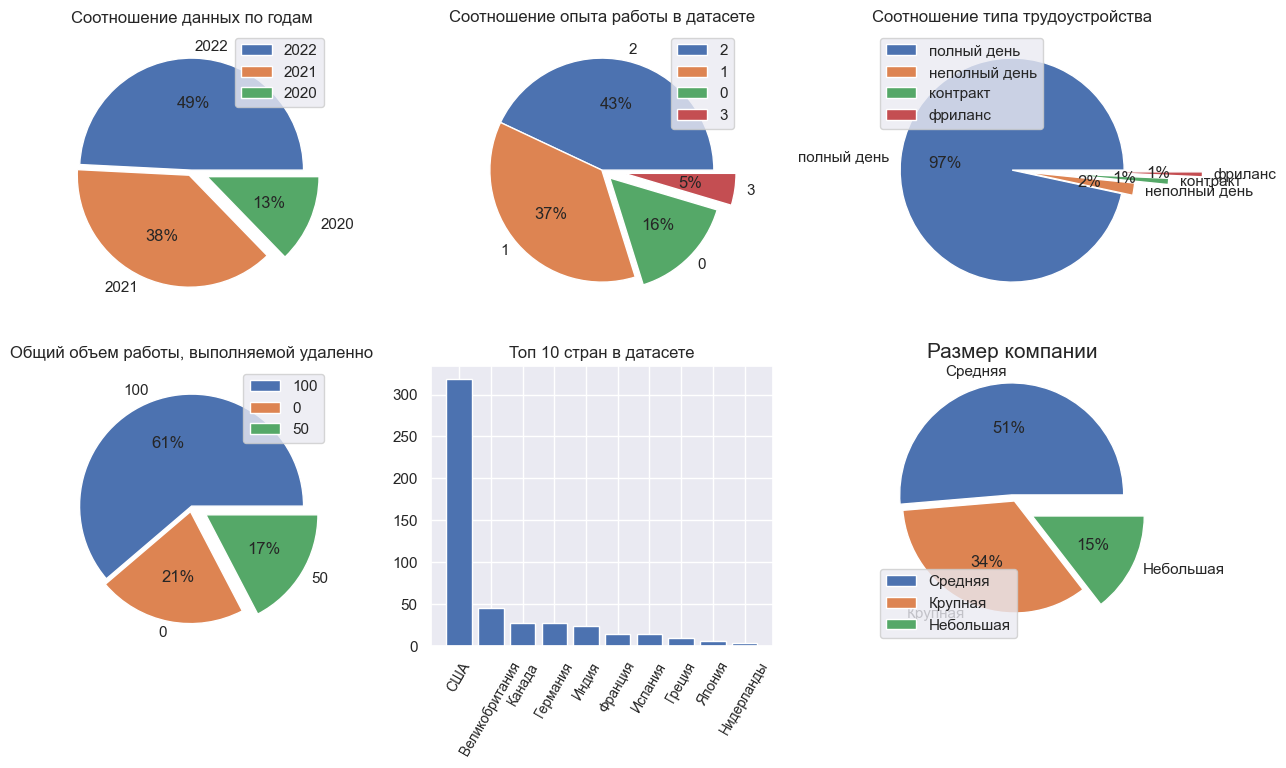

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

axes[0,0].pie(salaries['work_year'].value_counts(),
            labels = salaries['work_year'].value_counts().index,
            explode = [0, 0.05, 0.15],
            autopct='%.0f%%')
axes[0,0].set_title('Соотношение данных по годам')
axes[0,0].legend();

axes[0,1].pie(salaries['experience_level'].value_counts(),
            labels = salaries['experience_level'].value_counts().index,
            explode = [0, 0, 0.1, 0.2],
            autopct='%.0f%%')
axes[0,1].set_title('Соотношение опыта работы в датасете')
axes[0,1].legend();

axes[0,2].pie(salaries['employment_type'].value_counts(),
            labels = salaries['employment_type'].value_counts().index,
            explode = [0, 0.1, 0.4, 0.7],
            autopct='%.0f%%');
axes[0,2].set_title('Соотношение типа трудоустройства')
axes[0,2].legend();

axes[1,0].pie(salaries['remote_ratio'].value_counts(),
            labels = salaries['remote_ratio'].value_counts().index,
            explode = [0, 0.05, 0.15],
            autopct='%.0f%%')
axes[1,0].set_title('Общий объем работы, выполняемой удаленно')
axes[1,0].legend();

counties_data = salaries['location'].value_counts().nlargest(10).reset_index(name='counts')
axes[1,1].bar(data=counties_data,
              x='location',
              height='counts')
axes[1,1].set_title('Топ 10 стран в датасете')
axes[1,1].xaxis.set_tick_params(rotation = 60, labelsize = 10)
axes[1,1].grid()

axes[1,2].pie(salaries['company_size'].value_counts(),
            labels = salaries['company_size'].value_counts().index,
            explode = [0.1, -0.05, 0.2],
            autopct='%.0f%%')
axes[1,2].set_title('Размер компании', size=15)
axes[1,2].legend();

* Большинство данных представлено за 2022 год
* 80% данных - это данные о зарплате специлистов уровня *Middle* и *Senior*
* В датасете тип трудоустройства - полный день, занимает доминирующую позицию
* Более половины всей работы выполнялось удаленно
* Самая частовстречающаяся страна - США, более половины всех данных относятся к ней
* Половина всех компаний в датасете имеют в своем штате от 50 до 250 сотрудников

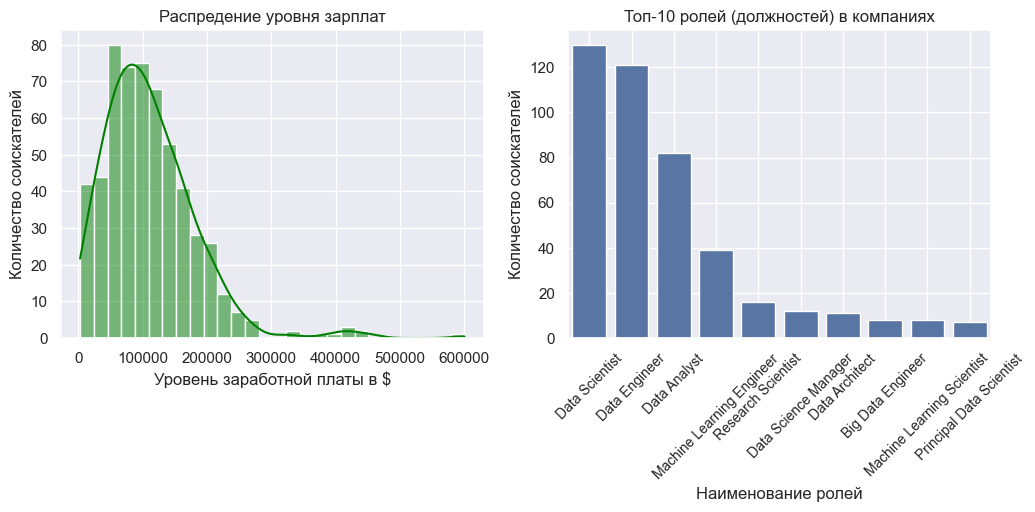

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=salaries['salary'],
            ax=axes[0],
            color = 'green',
            kde=True)

axes[0].set_title("Распредение уровня зарплат", fontsize = 12)
axes[0].set_xlabel('Уровень заработной платы в $', size = 12)
axes[0].set_ylabel('Количество соискателей')
axes[0].grid();

# Поскольку признак job_title содержит 50 разных значений, то возьмем 10 самый частовстречающихся:
job_data = salaries['job_title'].value_counts().nlargest(10).reset_index(name='counts')

sns.barplot(data=job_data,
            x='job_title',
            y='counts',
            ax=axes[1])

axes[1].xaxis.set_tick_params(rotation = 45, labelsize = 10)
axes[1].set_title("Топ-10 ролей (должностей) в компаниях", fontsize = 12);
axes[1].set_xlabel('Наименование ролей', size = 12)
axes[1].set_ylabel('Количество соискателей')
axes[1].grid();

* Распределение зарплат трудно назвать нормальным, скорее оно похоже на логнормальное
* Топ-3 роли представляют собой более половины датасета и они непосредственно связаны с data (данными)

#### *Попробуем ответить на вопросы HR-агентства с помощью визуализации:*

1. **Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

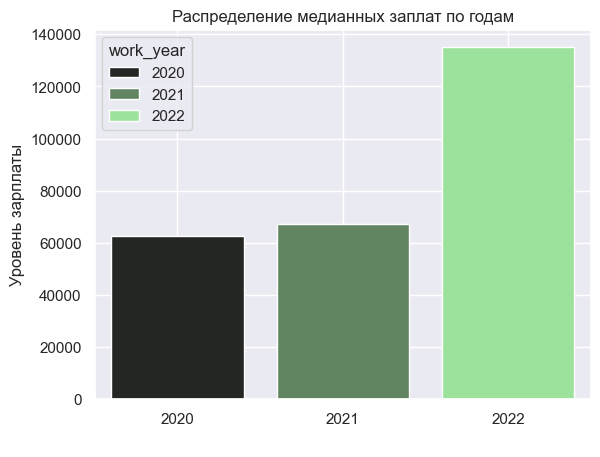

In [51]:
# Посколько распределение зарплат не является нормальным, то для ответа на вопрос будем использовать именно медианное значение

scientist_data = salaries[salaries['job_title'] == 'Data Scientist']
gropped = scientist_data.groupby(by='work_year')['salary'].median().reset_index(name='Уровень зарплаты')

bar = sns.barplot(data=gropped,
             x='work_year',
             y='Уровень зарплаты',
             palette='dark:lightgreen',
             hue='work_year')

bar.grid()
bar.set_title('Распределение медианных заплат по годам')
bar.set_xlabel(' ');

*Из графика видно, что медианная заплата растет с каждым годом*


2. **Как соотносятся зарплаты Data Scientist и Data Engineer?**

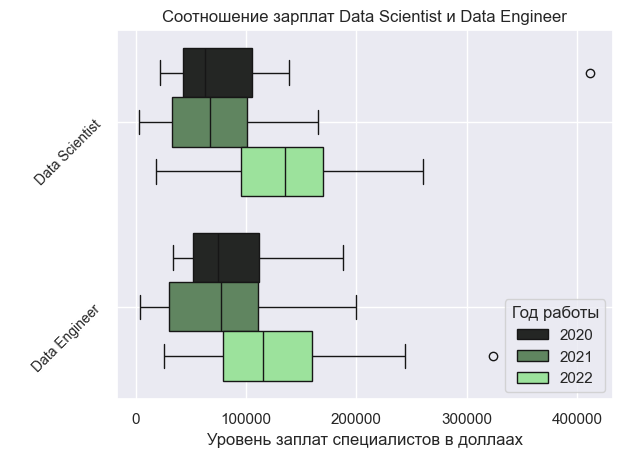

In [52]:
scientist_engineer_data = salaries[(salaries['job_title'] == 'Data Engineer')|(salaries['job_title'] == 'Data Scientist')]

box = sns.boxplot(data=scientist_engineer_data,
            x='salary',
            y='job_title',
            orient='h',
            palette="dark:lightgreen",
            hue='work_year')

box.grid()
box.legend(title = 'Год работы')
box.set_title('Соотношение зарплат Data Scientist и Data Engineer')
box.yaxis.set_tick_params(rotation = 45, labelsize = 10)
box.set_ylabel(' ')
box.set_xlabel('Уровень заплат специалистов в доллаах');

В 2022 году виден наглядный рост зарплат специалистов *Data Science*, по сравнению со специалистами *Data Enginering.* Медиана значительно вырасла у специалистов обоих типов, но если у дата инженеров в 2022 году медиана достигла уровня 75 квантили 2020-2021 годов, то у датасайентистов - а ж 25 квантиль практически дошла до уровней 75 квантилей за прошедшие года. Также у специалистов первой группы "вытянулось" само распределение зарплат: межквартильных рахмах стал куда больше, по сранению с 2020-2021 годами. А вот спеацилисты *Data Engineer* такими "достижениями" похвастаться не могут

3. **Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**

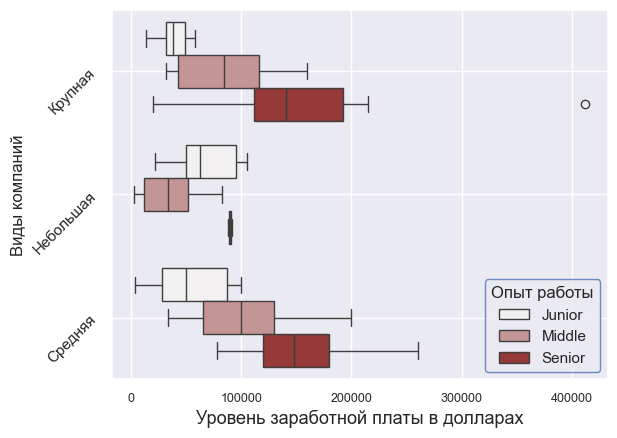

In [53]:
box = sns.boxplot(data=scientist_data,
              x='salary',
              y='company_size',
              hue='experience_level',
              palette='light:brown')

box.xaxis.set_tick_params(labelsize = 9)
box.yaxis.set_tick_params(rotation = 45, labelsize = 11)
box.set_xlabel('Уровень заработной платы в долларах', size=13)
box.set_ylabel('Виды компаний')
handles, _ = box.get_legend_handles_labels()
box.legend(handles, ['Junior','Middle','Senior'], edgecolor='b', title='Опыт работы')
box.grid();

Из графика видно, что небольшие компании не готовы платить большие деньги специалистам *Data Science*. Это нетрудно объяснить тем, что такие компании ввиду небольшого бюджета просто не делают ставку на специалистов уровня *Senior*, а обходятся более "дешевыми" вариантами. Тем более станно, что специалисты уровня *Middle* в небольших компаниях получают куда меньше, чем специалисты уровня *Junior*. Скорре всего это связано с малой выборкой данных. В средних и крупных компаниях какая-то четкая взаимосвязь по уровню заплат не прослеживается.

4. **Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?**

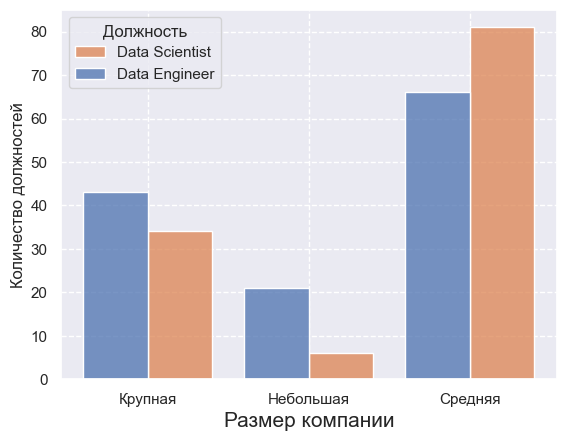

In [54]:
# Задаём порядок категорий, который Seaborn и Matplotlib учитывают при построении графика

order = ['Небольшая', 'Средняя', 'Крупная']
scientist_engineer_data.loc[:, 'company_size'] = pd.Categorical(
    scientist_engineer_data['company_size'],
    categories=order,
    ordered=True)

hist = sns.histplot(data=scientist_engineer_data,
             x='company_size',
             hue='job_title',
             multiple='dodge',
             shrink=0.8)

hist.set_xlabel('Размер компании', size=15)
hist.set_ylabel('Количество должностей')
hist.legend(['Data Scientist', 'Data Engineer'], title='Должность')
hist.grid(linestyle='--');

В компаниях, где штат составляет от 50 до 250 сотрудников, количество должностей *Data Scientist* и *Data Engineer* намного больше, чем в небольшой и крупной компаниях. Так же в средних компаниях дата инженеры более востребованы, нежели в двух других категориях. Четкой взаимосвязи между ростом размера компании и наличием в ней искомых должностей - нет.

5. **Посмотрим на уровень зарабнотной платы специалистов Data Science в разрезе стран:**

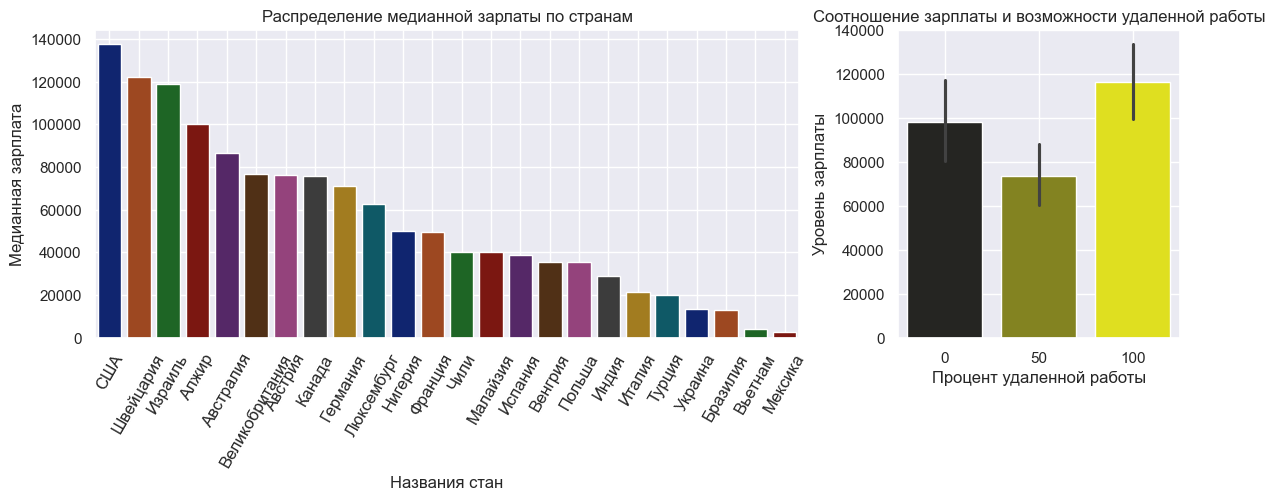

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), gridspec_kw={'width_ratios': [2.5, 1]})
gropped = scientist_data.groupby(by='location')['salary'].median().reset_index(name='salary')

sns.barplot(data=gropped.sort_values(by='salary', ascending=False),
            x='location',
            y='salary',
            hue='location',
            palette='dark',
            ax=axes[0])

axes[0].xaxis.set_tick_params(rotation = 60, labelsize = 12)
axes[0].set_title("Распределение медианной зарлаты по странам", fontsize = 12);
axes[0].set_xlabel('Названия стан', size = 12)
axes[0].set_ylabel('Медианная зарплата')
axes[0].grid();

sns.barplot(data=scientist_data,
            x='remote_ratio',
            y='salary',
            hue='remote_ratio',
            ax=axes[1],
            palette='dark:yellow',
            legend=False)

axes[1].set_title("Соотношение зарплаты и возможности удаленной работы", fontsize = 12);
axes[1].set_xlabel('Процент удаленной работы', size = 12)
axes[1].set_ylabel('Уровень зарплаты')
axes[1].grid();


Исходя из полученной визуализации можно сделать вывод о том, какие факторы влияют на заботную плату специалиста Data Science:
- Однозначно страна, в которой находится компания: самые большие зарплаты наблюдаются в таких странах как США, Швейцария, Израиль
- Возможность частичной/полностью удаленной работы не оказывает должного влияния на уровень заработной платы
- С ростом года в датасете уровень зарплаты также растет
- Размер компании также косвенно влияет на заработнуую плату: в маленьких компаниях он наименьший, а вот между средней и крупной компаниями разницы практически нет
- Опыт работы - это однозначно самый важный фактор, от которого зависит зарплата. Это также подтвеждают наши визуализации
- Рассматривать зависимость от типа трудоустройста нет никакого смысла, поскольку 97% составляет 'полный день'. Это значит, что по остальным категориям выборка будет слишком мала для того, чтобы сделать качественные выводы. Вероятно, этот признак стоило удалить раннее


## Статистический анализ данных

In [56]:
# Зададим две функции, которые немного упростят нам статистический анализ

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### 1. *Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?*


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средний уровень зарплат у специалистов Data Scientist за 2020-2022 года не отличается: $μ_1$ - средний уровень зарплат за 2020 год, $μ_2$ - за 2021, $μ_3$ - за 2022.

$$ H_0 : μ_1 = μ_2 = μ_3$$


*Альтернативная гипотеза*: средний уровень зарплат у специалистов Data Scientist за 2020-2022 отличается: $μ_1$ - средний уровень зарплат за 2020 год, $μ_2$ - за 2021, $μ_3$ - за 2022. Если альтернативная гипотеза окажется верна, то с большой долей вероятности можно будет утверждать, что уровень зарплат вырос, а не упал,  поскольку с течением времени цены растут в любой стране в связи с инфляцией, а этот фактор косвенно влияет на рост заплат во всех отраслях.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [57]:
# Для каждого признака созданим свою переменную:

ds_salary_2020 = scientist_data.loc[scientist_data['work_year']==2020, 'salary']
ds_salary_2021 = scientist_data.loc[scientist_data['work_year']==2021, 'salary']
ds_salary_2022 = scientist_data.loc[scientist_data['work_year']==2022, 'salary']

# проводим тест Шапиро-Уилка

print('За 2020 год:')
result = stats.shapiro(ds_salary_2020)
decision_normality(result[1])

print('За 2021 год:')
result = stats.shapiro(ds_salary_2021)
decision_normality(result[1])

print('За 2022 год:')
result = stats.shapiro(ds_salary_2022)
decision_normality(result[1])

За 2020 год:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
За 2021 год:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
За 2022 год:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. (Поскольку хотя бы один из признаков не распределен нормально) 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [58]:
# Проводим тест

_, p = stats.kruskal(ds_salary_2020, ds_salary_2021, ds_salary_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

У нас есть все основания утверждать, что средний уровень зарплат у специалистов Data Scientist за 2020-2022 отличается. А если обратиться к визуализации, которую мы получили ранее, то можно смело утверждать, что у специалистов Data Scientist ежегодный рост зарплат.

### 2. *Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?*

Глядя на визуализацию, можно заметить, что распределения приблизительно одинаковые, но у датасаентистов медиана чуть по-больше. Поэтому сформулируем гипотезы таким образом:

*Нулевая гипотеза* ($H_0$): уровень заработной платы у специлистов Data Scientist ($μ_1$) статистически больше либо равен уровеню заработной платы у специлистов Data Engineer ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): уровень заработной платы у специлистов Data Scientist ($μ_1$) статистически меньше, чем уровеню заработной платы у специлистов Data Engineer ($μ_2$).
$$ H_1 : μ_1 < μ_2$$

In [59]:
# Для каждого признака созданим свою переменную:

ds_salary_2022 # Уже сделали ранее
de_salary_2022 = salaries.loc[(salaries['work_year'] == 2022)&(salaries['job_title'] == 'Data Engineer'), 'salary']

# проводим тест Шапиро-Уилка

print('Датасайентисты 2022:')
result = stats.shapiro(ds_salary_2022)
decision_normality(result[1])

print('Датаинженеры 2022:')
result = stats.shapiro(de_salary_2022)
decision_normality(result[1])

Датасайентисты 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Датаинженеры 2022:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. (Поскольку хотя бы один из признаков не распределен нормально) 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [60]:
# проводим тест
_, p = stats.mannwhitneyu(ds_salary_2022, de_salary_2022, alternative='less')
decision_hypothesis(p)

p-value = 0.841
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что уровень заработной платы у специлистов Data Scientist статистически меньше, чем уровеню заработной платы у специлистов Data Engineer. Получается, что наши догадки, основанные на визуализции оказались верны.

### 3. *Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?*

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средний уровень зарплат у специалистов Data Scientist в компаниях различных размеров не отличается: $μ_1$ - средний уровень зарплат у специалистов Data Scientist в небольшой компании, $μ_2$ - в средней, $μ_3$ - в крупной.

$$ H_0 : μ_1 = μ_2 = μ_3$$


*Альтернативная гипотеза*: средний уровень зарплат у специалистов Data Scientist в компаниях различных размеров отличается: $μ_1$ - средний уровень зарплат у специалистов Data Scientist в небольшой компании, $μ_2$ - в средней, $μ_3$ - в крупной.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [61]:
# Для каждого признака созданим свою переменную:

ds_salary_small_company = scientist_data.loc[scientist_data['company_size']=='Небольшая', 'salary']
ds_salary_medium_company = scientist_data.loc[scientist_data['company_size']=='Средняя', 'salary']
ds_salary_large_company = scientist_data.loc[scientist_data['company_size']=='Крупная', 'salary']

# проводим тест Шапиро-Уилка

print('Небольшая компания:')
result = stats.shapiro(ds_salary_small_company)
decision_normality(result[1])

print('Средняя компания:')
result = stats.shapiro(ds_salary_medium_company)
decision_normality(result[1])

print('Крупная компания:')
result = stats.shapiro(ds_salary_large_company)
decision_normality(result[1])

Небольшая компания:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Средняя компания:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Крупная компания:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. (Поскольку хотя бы один из признаков не распределен нормально) 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [62]:
# Проводим тест

_, p = stats.kruskal(ds_salary_small_company, ds_salary_medium_company, ds_salary_large_company)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


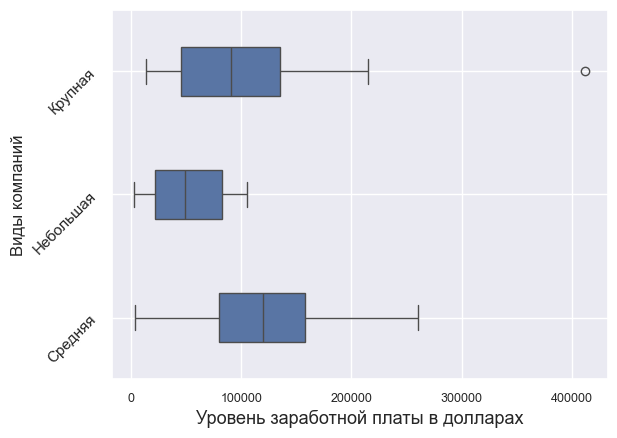

In [63]:
box = sns.boxplot(data=scientist_data,
              x='salary',
              y='company_size',
              width=0.4)

box.xaxis.set_tick_params(labelsize = 9)
box.yaxis.set_tick_params(rotation = 45, labelsize = 11)
box.set_xlabel('Уровень заработной платы в долларах', size=13)
box.set_ylabel('Виды компаний')
box.grid();

**Вывод**

У нас есть все основания утверждать, что средний уровень зарплат у специалистов Data Scientist в компаниях различных размеров отличается. А если обратиться к визуализации, то можно утверждать, что по мере роста компании растет и уровень заработной платы.

### 4. *Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?*

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза ($H_0$)*:
Наличие должностей Data Scientist и Data Engineer не зависит от размера компании. То есть распределение сотрудников с этими должностями равномерно по малым (S), средним (M) и крупным (L) компаниям.

*Альтернативная гипотеза ($H_1$)*:
Наличие должностей Data Scientist и Data Engineer зависит от размера компании.
Например, крупные компании (L) имеют статистически значимо больше сотрудников с этими должностями, чем малые (S) или средние (L).



Для начала зададим бинарные признаки для должностей Data Scientist и Data Engineer. Для этого напиешм функию *contains_words*

In [64]:
def contain_words(string, word1, word2):
    '''Функция contain_words принимает на вход 3 строки.
    Она возвращает True, если в первой строке есть оба
    слова и word1, и word2.
    '''
    words = list(string.split())
    return (word1 in words) and (word2 in words)

# Создадим булевые признаки is_scientist и is_engineer:

salaries['is_scientist'] = salaries['job_title'].apply(lambda x: contain_words(x, 'Data', 'Scientist'))
salaries['is_engineer'] = salaries['job_title'].apply(lambda x: contain_words(x, 'Data', 'Engineer'))

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [65]:
# составляем таблицу сопряжённости

table1 = pd.crosstab(salaries['is_scientist'], salaries['company_size'])
table2 = pd.crosstab(salaries['is_engineer'], salaries['company_size'])

table1, '-'*40, table2

(company_size  Крупная  Небольшая  Средняя
 is_scientist                             
 False             140         59      220
 True               53         23       70,
 '----------------------------------------',
 company_size  Крупная  Небольшая  Средняя
 is_engineer                              
 False             147         69      202
 True               46         13       88)

In [66]:
# проводим тест

_, p1, _, _ = stats.chi2_contingency(table1)
decision_hypothesis(p1)

_, p2, _, _ = stats.chi2_contingency(table2)
decision_hypothesis(p2)

p-value = 0.634
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.021
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

В случае с должностью датасаентиста нет статистически значимой связи. А вот у дата инженеров существует статистически значимая взаимосвязь между наличием данной должности в компаниях и их размеров. Хотя при визуализации данных мы сделали другой вывод.

После ответа на вопросы HR-агентства попробуем сформулировать свои гипотезы:

1. Влияет ли уровень опыта влияет на заработную плату специалистов по всем должностям
2. Отличается ли средняя зарплата специалистов Data Scientist, работающих полностью удалённо (remote_ratio=100), от медианной зарплаты по всей выборке. Мы получили ее ранее и она равна
100000.0 долларов.

### 5. *Влияет ли уровень опыта влияет на заработную плату специалистов по всех должностям*

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Средние зарплаты специалистов Entry-level/Junior ($μ_1$), Mid-level/Intermediate ($μ_2$), Senior-level/Expert ($μ_3$), Executive-level/Director (($μ_4$)) одинаковы.

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$): Средние зарплаты специалистов хотя бы в одной группе опыта отличаются.

$$ H_0 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [67]:
# Для каждого признака созданим свою переменную:

junior = salaries.loc[salaries['experience_level'] == 0, 'salary']
middle = salaries.loc[salaries['experience_level'] == 1, 'salary']
senior = salaries.loc[salaries['experience_level'] == 2, 'salary']
director = salaries.loc[salaries['experience_level'] == 3, 'salary']

# проводим тест Шапиро-Уилка
print('Junior:')
result = stats.shapiro(junior)
decision_normality(result[1])

print('Middle:')
result = stats.shapiro(middle)
decision_normality(result[1])

print('Senior:')
result = stats.shapiro(senior)
decision_normality(result[1])

print('Director:')
result = stats.shapiro(director)
decision_normality(result[1])

Junior:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Middle:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Senior:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Director:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 


Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [68]:
# проводим тест
_, p = stats.kruskal(junior, middle, senior, director)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


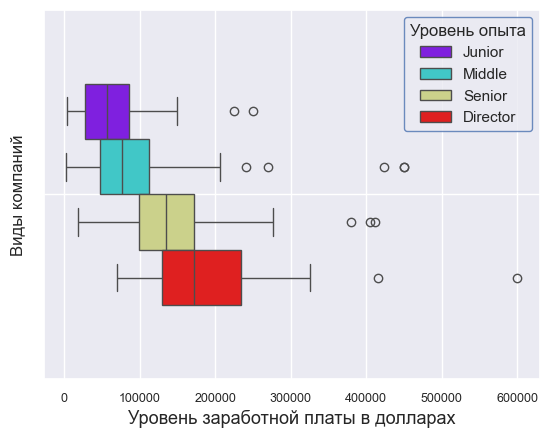

In [69]:
# Визуализируем нашу задачу

box = sns.boxplot(data=salaries,
              x='salary',
              hue='experience_level',
              palette='rainbow',
              width=0.6)

box.xaxis.set_tick_params(labelsize = 9)
box.yaxis.set_tick_params(rotation = 45, labelsize = 11)
box.set_xlabel('Уровень заработной платы в долларах', size=13)
box.set_ylabel('Виды компаний')
handles, _ = box.get_legend_handles_labels()
box.legend(handles, ['Junior','Middle','Senior','Director'], edgecolor='b', title='Уровень опыта')
box.grid();

**Вывод**

Поскольку p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной. Это значит, что заплаты специалистов с разным опытом отличаются. Что кстати нетрудно заметить и на визуализации. Теперь можно сделать однозначный вывод, что уровень заработной платы прямо прорционален опыту сотрудника, то есть опыт - это важнейший фактор, который влияет на уровень заработной платы.

### 6. *Отличается ли средняя зарплата специалистов Data Scientist, работающих полностью удалённо, от медианной зарплаты по всей выборке*

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$):  Средняя зарплата специалистов Data Scientist с remote_ratio=100 равна 100000 долларам.

*Альтернативная гипотеза* ($H_1$): Средняя зарплата специалистов Data Scientist с remote_ratio=100 не равно 100000 долларам.

In [70]:
# С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

ds_remote_100 = scientist_data.loc[scientist_data['remote_ratio']==100, 'salary']

# проводим тест Шапиро-Уилка

result = stats.shapiro(ds_remote_100)
decision_normality(result[1])

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Нет. 


Для проверки нашей гипотезы можно использовать критерий знаков (для одной выборки).

**Проведём тест**

In [71]:
# проводим тест

# проводим тест
_, p = sms.descriptivestats.sign_test(ds_remote_100, 100000)
decision_hypothesis(p)


p-value = 0.215
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [72]:
ds_remote_100.median()

111500.0

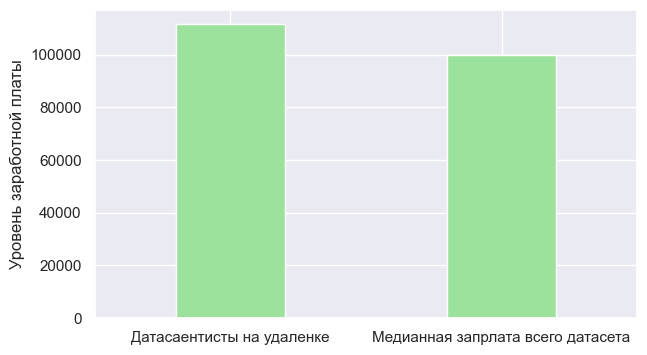

In [73]:
# Визуализируем нашу задачу
fig = plt.figure(figsize=(7, 4))

medians = [ds_remote_100.median(), salaries['salary'].median()]
labels = ['Датасаентисты на удаленке', 'Медианная запрлата всего датасета']

bar = sns.barplot(x=labels,
                  y=medians,
                  color='lightgreen',
                  width=0.4)

bar.set_ylabel('Уровень заработной платы')
bar.grid();

**Вывод**

Нет оснований утверждать, что средняя зарплата специалистов Data Scientist, работающих полностью удалённо, отличается от 100000 долларов. Также на графике видно, что отличие между медианами зарплат минимально

## Итоговые результаты исследования

В ходе анализа данных по зарплатам специалистов в сфере Data Science и Data Engineering были получены следующие ключевые результаты:

- ##### Ежегодный рост зарплат специалистов Data Scientist
Анализ показал, что наблюдается стабильный ежегодный рост заработных плат у Data Scientist, что отражает растущий спрос и ценность этой профессии на рынке.

- ##### Сравнение зарплат Data Scientist и Data Engineer в 2022 году
В 2022 году различие между средними и медианными зарплатами специалистов Data Scientist и Data Engineer несущественно.
Это может означать, что компании рассматривают обе роли как равноценные по уровню ответственности и квалификации.

- ##### Влияние размера компании на зарплаты Data Scientist
Зарплаты Data Scientist зависят от размера компании: специалисты в крупных компаниях получают значительно выше, чем в небольших и средних, что подтверждает влияние корпоративного масштаба на уровень вознаграждения.

- ##### Связь между наличием должностей Data Scientist и Data Engineer и размером компании
Статистический анализ показал, что наличие должности Data Engineer тесно связано с размером компании, в то время как для Data Scientist такой связи не выявлено. Это может отражать разные кадровые стратегии и потребности компаний разного масштаба.

- ##### Влияние уровня опыта на заработную плату специалистов по всем должностям
Уровень опыта является значимым фактором, влияющим на зарплату: специалисты с более высоким уровнем (Senior, Executive) получают существенно больше, чем Junior и Mid-level сотрудники. Это подтверждается статистическим тестированием и визуализацией распределений зарплат.

- ##### Отличается ли средняя зарплата Data Scientist с полной удалёнкой от медианной зарплаты по всей выборке
Проверка гипотезы показала, что средняя зарплата Data Scientist, работающих полностью удалённо (remote_ratio=100), статистически не отличается от медианной зарплаты по всей выборке, которая равна 100000 долларов. Это говорит о том, что работодатели готовы платить удалённым сотрудникам сопоставимые с остальными специалистами зарплаты, что подтверждает устойчивость и зрелость практики удалённой работы в данной сфере. Таким образом, специалисты с полной удалёнкой имеют равные возможности по доходу с коллегами, работающими в офисе или гибридно.

**Общий вывод:**

Зарплата Data Scientist формируется под влиянием комплексного набора факторов, где ключевыми являются опыт, размер компании и регион работы. Формат удалённой работы не снижает уровень дохода, что подтверждает современные тенденции рынка труда. Для специалистов важно развивать навыки и накапливать опыт, а работодателям — учитывать эти факторы при формировании конкурентных предложений.